# **Project Assignment // Group ID 12**
***Group Members***
> Yiğitcan Darcan <br> Görkem Köse <br> Deniz Cangı <br> Doğukan Yıldırım

# Setting the random seeds

Setting random seeds for reproducibility.

In [1]:
import numpy as np
import tensorflow as tf
import random as python_random

np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(1234)

# Loading the datasets

Importing required libraries and mounting to Google Drive.

In [2]:
import cv2
import os
import string
from os.path import join
import matplotlib.pyplot as plt
from PIL import Image
import regex as re

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzipping the file to Colab.

In [3]:
!unzip "/content/drive/My Drive/CS412PROJ_DATA/cs412-spring-2021.zip" -d "/content/data"

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/data/train_data/train/Y/0.jpg  
  inflating: /content/data/train_data/train/Y/1.jpg  
  inflating: /content/data/train_data/train/Y/10.jpg  
  inflating: /content/data/train_data/train/Y/100.jpg  
  inflating: /content/data/train_data/train/Y/101.jpg  
  inflating: /content/data/train_data/train/Y/102.jpg  
  inflating: /content/data/train_data/train/Y/103.jpg  
  inflating: /content/data/train_data/train/Y/104.jpg  
  inflating: /content/data/train_data/train/Y/105.jpg  
  inflating: /content/data/train_data/train/Y/106.jpg  
  inflating: /content/data/train_data/train/Y/107.jpg  
  inflating: /content/data/train_data/train/Y/108.jpg  
  inflating: /content/data/train_data/train/Y/109.jpg  
  inflating: /content/data/train_data/train/Y/11.jpg  
  inflating: /content/data/train_data/train/Y/110.jpg  
  inflating: /content/data/train_data/train/Y/111.jpg  
  inflating: /content/data/train_data/train/Y/112.jpg  
  infla

Creating a dictionary of labels so that we can store the golden labels as numerical values.

In [4]:
labels = {k: v for v, k in enumerate(list(string.ascii_uppercase))}
labels["space"] = 26
labels["del"] = 27
labels["nothing"] = 28
print(labels)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'space': 26, 'del': 27, 'nothing': 28}


Functions to load the images.

In [5]:
# Function taken and modified from: https://github.com/libvips/pyvips/issues/179
def readImage(f, img_size): 
    im = Image.open(f)  
    im.draft('RGB', img_size)  
    return np.asarray(im)

In [6]:
def load_datasets():
  
  DEBUG = False
  data_path = "/content/data/"
  X_train = []
  y_train = []
  img_size = 100,100

  if DEBUG: print("Loading X_train, y_train")
  for folder_name in os.listdir(join(data_path,"train_data/train")):
    if DEBUG: print(f"— Letter: {folder_name}")
    for count, image_file in enumerate(sorted(os.listdir(join(data_path,"train_data/train", folder_name)), key=lambda f: int(re.sub('\D', '', f)))):
      if DEBUG: print(f"—— {count+1}/1000, {image_file}")
      img = readImage(join(data_path,"train_data/train", folder_name, image_file), img_size)
      if img is not None:
        X_train.append(img)
        y_train.append(labels[folder_name])

  X_train = np.array(X_train)
  y_train = np.array(y_train)

  X_test = []

  if DEBUG: print("\nLoading X_test")
  for count, image_file in enumerate(sorted(os.listdir(join(data_path,"test_data/nonlabeled-test")), key=lambda f: int(re.sub('\D', '', f)))):
    if DEBUG: print(f"—— {count+1}/7250, {image_file}")
    img = readImage(join(data_path,"test_data/nonlabeled-test", image_file), img_size)
    if img is not None:
      X_test.append(img)
  
  X_test = np.array(X_test)

  if DEBUG: print()
  print("Loaded the images.")

  return X_train, y_train, X_test

Loading the datasets.

In [7]:
X_train, y_train, X_test = load_datasets()

Loaded the images.


Plotting sample images.

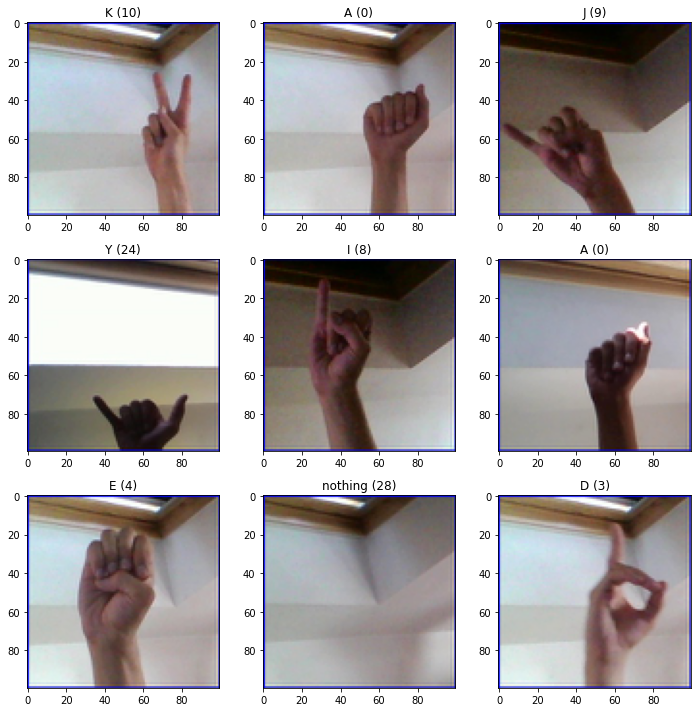

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(10,10))

for i in range(3):
  for j in range(3):
    random_number = python_random.randint(0,len(X_train) - 1)
    axes[i][j].imshow(X_train[random_number])
    axes[i][j].set_title([k for k, v in labels.items() if y_train[random_number] == v][0] + f" ({y_train[random_number]})")

fig.tight_layout()

Displaying useful information and checking for anomalies.

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X_train max: {X_train.max()}")
print(f"X_train min: {X_train.min()}")
print(f"X_test max: {X_test.max()}")
print(f"X_test min: {X_test.min()}")
print(f"y_train unique values: {list(np.unique(y_train))}")

X_train shape: (29000, 100, 100, 3)
y_train shape: (29000,)
X_test shape: (7250, 100, 100, 3)
X_train max: 255
X_train min: 0
X_test max: 255
X_test min: 0
y_train unique values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


# Preprocessing

Normalizing.

In [8]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

One-hot encoding the labels.

In [9]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, 29)

Splitting train set to train and validation sets.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=987)

# CNN

Importing the required libraries.

In [12]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import keras.backend as K
import pandas as pd
from keras.optimizers import Adam, SGD

## Model 1

In [ ]:
model = Sequential([
  Conv2D(filters=16, kernel_size=7, strides=1, padding = 'same', activation='relu', input_shape=X_train.shape[1:]),
  MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),

  Conv2D(filters=32, kernel_size=7, strides=1, padding = 'same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),

  Conv2D(filters=64, kernel_size=7, strides=2, padding = 'same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),

  Conv2D(filters=128, kernel_size=7, strides=2, padding = 'same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),


  Flatten(),
  Dense(128, activation='relu'),
  Dense(64, activation='relu'),
  Dense(29, activation='softmax')
])

model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 100, 100, 16)      2368      
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 100, 100, 32)      25120     
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 50, 50, 64)        100416    
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 25, 25, 128)     

In [ ]:
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

filepath="weights.model4.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=256, epochs=50, callbacks=callbacks_list)

Epoch 1/50
91/91 [==============================] - 50s 473ms/step - loss: 3.1212 - accuracy: 0.1189 - val_loss: 2.0614 - val_accuracy: 0.4021

Epoch 00001: val_accuracy improved from -inf to 0.40207, saving model to weights.model4.hdf5
Epoch 2/50
91/91 [==============================] - 35s 380ms/step - loss: 1.8188 - accuracy: 0.4739 - val_loss: 1.2200 - val_accuracy: 0.6253

Epoch 00002: val_accuracy improved from 0.40207 to 0.62534, saving model to weights.model4.hdf5
Epoch 3/50
91/91 [==============================] - 35s 384ms/step - loss: 1.0217 - accuracy: 0.6910 - val_loss: 0.8104 - val_accuracy: 0.7455

Epoch 00003: val_accuracy improved from 0.62534 to 0.74552, saving model to weights.model4.hdf5
Epoch 4/50
91/91 [==============================] - 35s 385ms/step - loss: 0.6449 - accuracy: 0.8056 - val_loss: 0.5500 - val_accuracy: 0.8305

Epoch 00004: val_accuracy improved from 0.74552 to 0.83052, saving model to weights.model4.hdf5
Epoch 5/50
91/91 [=========================

With this model, maximum `val_accuracy` is 0.96655.

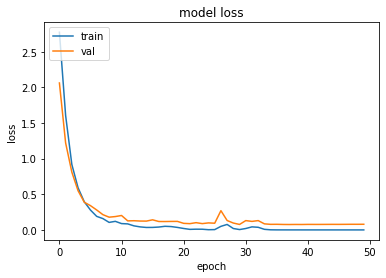

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##Model 2

In [ ]:
model = Sequential([
  Conv2D(filters=8, kernel_size=(7,7), strides=1, padding = 'same', activation='relu', input_shape=X_train.shape[1:]),
  MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),

  Conv2D(filters=16, kernel_size=(7,7), strides=1, padding = 'same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),

  Conv2D(filters=32, kernel_size=(7,7), strides=2, padding = 'same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),

  Conv2D(filters=64, kernel_size=(7,7), strides=2, padding = 'same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),

  Conv2D(filters=128, kernel_size=(7,7), strides=2, padding = 'same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),

  Conv2D(filters=256, kernel_size=(7,7), strides=2, padding = 'same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),

  Flatten(),
  Dense(128, activation='relu'),
  Dense(64, activation='relu'),
  Dense(29, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 8)       1184      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 16)      6288      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        25120     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)        1

Compiling and training the model with checkpoint callback to save the `best` weights that give the highest validation accuracy.

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

filepath="weights.best.128.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
model.fit(X_train, y_train,validation_data = (X_valid, y_valid), batch_size=128, epochs=100, callbacks=callbacks_list)

Epoch 1/100
182/182 [==============================] - 22s 114ms/step - loss: 2.9692 - accuracy: 0.1437 - val_loss: 0.9865 - val_accuracy: 0.6871

Epoch 00001: val_accuracy improved from -inf to 0.68707, saving model to weights.best.0.2.split.hdf5
Epoch 2/100
182/182 [==============================] - 21s 114ms/step - loss: 0.6330 - accuracy: 0.7957 - val_loss: 0.1995 - val_accuracy: 0.9317

Epoch 00002: val_accuracy improved from 0.68707 to 0.93172, saving model to weights.best.0.2.split.hdf5
Epoch 3/100
182/182 [==============================] - 21s 114ms/step - loss: 0.1663 - accuracy: 0.9423 - val_loss: 0.1488 - val_accuracy: 0.9547

Epoch 00003: val_accuracy improved from 0.93172 to 0.95466, saving model to weights.best.0.2.split.hdf5
Epoch 4/100
182/182 [==============================] - 20s 112ms/step - loss: 0.1132 - accuracy: 0.9643 - val_loss: 0.1228 - val_accuracy: 0.9647

Epoch 00004: val_accuracy improved from 0.95466 to 0.96466, saving model to weights.best.0.2.split.hdf5

With this model, maximum `val_accuracy` is 99.879%.

In [ ]:
del model

## Model 3

Trying out a different learning rate of 0.00001 and batch size 128.

In [ ]:
model_learningrate = Sequential([
  Conv2D(filters=8, kernel_size=(7,7), strides=1, padding = 'same', activation='relu', input_shape=X_train.shape[1:]),
  MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),

  Conv2D(filters=16, kernel_size=(7,7), strides=1, padding = 'same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),

  Conv2D(filters=32, kernel_size=(7,7), strides=2, padding = 'same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),

  Conv2D(filters=64, kernel_size=(7,7), strides=2, padding = 'same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),

  Conv2D(filters=128, kernel_size=(7,7), strides=2, padding = 'same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),

  Conv2D(filters=256, kernel_size=(7,7), strides=2, padding = 'same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),

  Flatten(),
  Dense(128, activation='relu'),
  Dense(64, activation='relu'),
  Dense(29, activation='softmax')
])

model_learningrate.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 100, 100, 8)       1184      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 100, 100, 8)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 100, 100, 16)      6288      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 50, 50, 32)        25120     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 25, 25, 64)       

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
filepath="weights.best.lr.split.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#es = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min',restore_best_weights=True)
#callbacks_list = [checkpoint, es]
callbacks_list = [checkpoint]

In [ ]:
model.fit(X_train, y_train,validation_data = (X_valid, y_valid), batch_size=128, epochs=100, callbacks=callbacks_list)

Epoch 1/100
182/182 [==============================] - 23s 118ms/step - loss: 3.3573 - accuracy: 0.0487 - val_loss: 3.2131 - val_accuracy: 0.1050

Epoch 00001: val_accuracy improved from -inf to 0.10500, saving model to weights.best.lr.split.hdf5
Epoch 2/100
182/182 [==============================] - 22s 119ms/step - loss: 3.0911 - accuracy: 0.1417 - val_loss: 2.7805 - val_accuracy: 0.2147

Epoch 00002: val_accuracy improved from 0.10500 to 0.21466, saving model to weights.best.lr.split.hdf5
Epoch 3/100
182/182 [==============================] - 21s 118ms/step - loss: 2.6633 - accuracy: 0.2341 - val_loss: 2.3399 - val_accuracy: 0.3129

Epoch 00003: val_accuracy improved from 0.21466 to 0.31293, saving model to weights.best.lr.split.hdf5
Epoch 4/100
182/182 [==============================] - 21s 117ms/step - loss: 2.2015 - accuracy: 0.3596 - val_loss: 1.9955 - val_accuracy: 0.4066

Epoch 00004: val_accuracy improved from 0.31293 to 0.40655, saving model to weights.best.lr.split.hdf5
Epo

With this model, maximum `val_accuracy` is 0.98362.


## Model 4

Trying out a different batch size of 256, and keeping learning rate as default.

In [ ]:
model_batch = Sequential([
  Conv2D(filters=8, kernel_size=(7,7), strides=1, padding = 'same', activation='relu', input_shape=X_train.shape[1:]),
  MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),

  Conv2D(filters=16, kernel_size=(7,7), strides=1, padding = 'same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),

  Conv2D(filters=32, kernel_size=(7,7), strides=2, padding = 'same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),

  Conv2D(filters=64, kernel_size=(7,7), strides=2, padding = 'same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),

  Conv2D(filters=128, kernel_size=(7,7), strides=2, padding = 'same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),

  Conv2D(filters=256, kernel_size=(7,7), strides=2, padding = 'same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),

  Flatten(),
  Dense(128, activation='relu'),
  Dense(64, activation='relu'),
  Dense(29, activation='softmax')
])

model_batch.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 100, 100, 8)       1184      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 100, 100, 8)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 100, 100, 16)      6288      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 50, 50, 32)        25120     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 25, 25, 64)       

In [ ]:
model_batch.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

filepath="weights.batch-256.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model_batch.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=256, epochs=100, callbacks=callbacks_list)

Epoch 1/100
91/91 [==============================] - 31s 276ms/step - loss: 3.2754 - accuracy: 0.0579 - val_loss: 2.1659 - val_accuracy: 0.3429

Epoch 00001: val_accuracy improved from -inf to 0.34293, saving model to weights.batch-256.hdf5
Epoch 2/100
91/91 [==============================] - 20s 221ms/step - loss: 1.7165 - accuracy: 0.4662 - val_loss: 0.8191 - val_accuracy: 0.7333

Epoch 00002: val_accuracy improved from 0.34293 to 0.73328, saving model to weights.batch-256.hdf5
Epoch 3/100
91/91 [==============================] - 20s 220ms/step - loss: 0.6156 - accuracy: 0.7907 - val_loss: 0.5512 - val_accuracy: 0.8133

Epoch 00003: val_accuracy improved from 0.73328 to 0.81328, saving model to weights.batch-256.hdf5
Epoch 4/100
91/91 [==============================] - 20s 221ms/step - loss: 0.2959 - accuracy: 0.8981 - val_loss: 0.1827 - val_accuracy: 0.9400

Epoch 00004: val_accuracy improved from 0.81328 to 0.94000, saving model to weights.batch-256.hdf5
Epoch 5/100
91/91 [========

With this model, maximum `val_accuracy` is 0.99724.

## Model 5

With batch size 256, and learning rate 0.0001.

In [ ]:
#new model
model = Sequential([
  Conv2D(filters=8, kernel_size=(7,7), strides=1, padding = 'same', activation='relu', input_shape=X_train.shape[1:]),
  MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),

  Conv2D(filters=16, kernel_size=(7,7), strides=1, padding = 'same', activation='relu', input_shape=X_train.shape[1:]),
  MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),

  Conv2D(filters=32, kernel_size=(7,7), strides=2, padding = 'same', activation='relu', input_shape=X_train.shape[1:]),
  MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),

  Conv2D(filters=64, kernel_size=(7,7), strides=2, padding = 'same', activation='relu', input_shape=X_train.shape[1:]),
  MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),

  Conv2D(filters=128, kernel_size=(7,7), strides=2, padding = 'same', activation='relu', input_shape=X_train.shape[1:]),
  MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),

  Conv2D(filters=256, kernel_size=(7,7), strides=2, padding = 'same', activation='relu', input_shape=X_train.shape[1:]),
  MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),

  Flatten(),
  Dense(128, activation='relu'),
  Dense(64, activation='relu'),
  Dense(29, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 100, 100, 8)       1184      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 100, 100, 8)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 100, 100, 16)      6288      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 50, 32)        25120     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 25, 25, 64)       

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
filepath="weights.best.lr.split.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
model.fit(X_train, y_train,validation_data = (X_valid, y_valid), batch_size=256, epochs=100, callbacks=callbacks_list)

Epoch 1/100
91/91 [==============================] - 70s 261ms/step - loss: 3.3117 - accuracy: 0.0636 - val_loss: 2.5988 - val_accuracy: 0.2405

Epoch 00001: val_accuracy improved from -inf to 0.24052, saving model to weights.best.lr.split.hdf5
Epoch 2/100
91/91 [==============================] - 20s 220ms/step - loss: 2.2451 - accuracy: 0.3475 - val_loss: 1.6514 - val_accuracy: 0.4997

Epoch 00002: val_accuracy improved from 0.24052 to 0.49966, saving model to weights.best.lr.split.hdf5
Epoch 3/100
91/91 [==============================] - 20s 223ms/step - loss: 1.3545 - accuracy: 0.5999 - val_loss: 0.9620 - val_accuracy: 0.7209

Epoch 00003: val_accuracy improved from 0.49966 to 0.72086, saving model to weights.best.lr.split.hdf5
Epoch 4/100
91/91 [==============================] - 20s 221ms/step - loss: 0.8800 - accuracy: 0.7329 - val_loss: 0.6929 - val_accuracy: 0.7914

Epoch 00004: val_accuracy improved from 0.72086 to 0.79138, saving model to weights.best.lr.split.hdf5
Epoch 5/100

With this model, maximum val_accuracy is 0.99672.

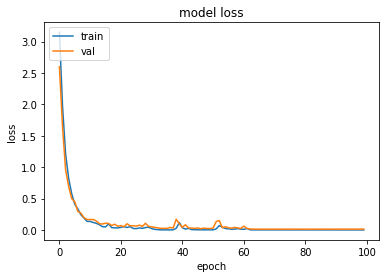

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Transfer Learning

Importing required libraries.

In [ ]:
from keras.layers import Input
from keras import Model

## VGG16

### Hyperparameter Tuning

*   Change trainable layers
*   Change batch size
*   Change learning rate





First tuned the trainable layers

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Input
from keras.optimizers import Adam
from keras import Model

vgg16_model = VGG16(include_top = False, weights = 'imagenet')
vgg16_input = Input(shape=(100,100,3), name = 'image_input')
output_vgg16_conv = vgg16_model(vgg16_input)


58892288/58889256 [==============================] - 1s 0us/step
The following Variables were used a Lambda layer's call (tf.nn.convolution), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv2/kernel:0' sh

First freezed all the pretrained convolutional layers

In [ ]:
for layer in vgg16_model.layers:
    layer.trainable = False

Add the dense layers to the pretrained model, used the learning rate 0.0001, batch_size 256 with epoch 10

In [ ]:
y = Flatten(name='flatten')(output_vgg16_conv)
y = Dense(1024, activation='relu')(y)
y = Dense(512, activation='relu')(y)
y = Dense(256, activation='relu')(y)
y = Dense(128, activation='relu')(y)
y = Dense(29, activation='softmax')(y)   

vgg16_model = Model(vgg16_input, y)
vgg16_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
vgg16_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=256, epochs=10)

Epoch 1/10
91/91 [==============================] - 87s 423ms/step - loss: 2.7458 - accuracy: 0.3419 - val_loss: 0.9411 - val_accuracy: 0.7848
Epoch 2/10
91/91 [==============================] - 28s 309ms/step - loss: 0.7231 - accuracy: 0.8539 - val_loss: 0.3840 - val_accuracy: 0.9250
Epoch 3/10
91/91 [==============================] - 27s 301ms/step - loss: 0.3181 - accuracy: 0.9434 - val_loss: 0.2326 - val_accuracy: 0.9564
Epoch 4/10
91/91 [==============================] - 27s 295ms/step - loss: 0.1892 - accuracy: 0.9648 - val_loss: 0.1542 - val_accuracy: 0.9709
Epoch 5/10
91/91 [==============================] - 27s 302ms/step - loss: 0.1238 - accuracy: 0.9807 - val_loss: 0.1208 - val_accuracy: 0.9764
Epoch 6/10
91/91 [==============================] - 27s 303ms/step - loss: 0.0912 - accuracy: 0.9863 - val_loss: 0.0845 - val_accuracy: 0.9866
Epoch 7/10
91/91 [==============================] - 27s 301ms/step - loss: 0.0685 - accuracy: 0.9906 - val_loss: 0.0646 - val_accuracy: 0.9912

In [ ]:
del vgg16_model

The next model:

In [ ]:
vgg16_model = VGG16(include_top = False, weights = 'imagenet')
vgg16_input = Input(shape=(100,100,3), name = 'image_input')
output_vgg16_conv = vgg16_model(vgg16_input)

The following Variables were used a Lambda layer's call (tf.nn.convolution_13), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_13), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_14), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this

Unfreeze the last 5 layers:

In [ ]:
for layer in vgg16_model.layers[:-5]:
    layer.trainable = False

Add dense layers, learning rate 0.0001, catch size 256 and epoch 10

In [ ]:
y = Flatten(name='flatten')(output_vgg16_conv)
y = Dense(1024, activation='relu')(y)
y = Dense(512, activation='relu')(y)
y = Dense(256, activation='relu')(y)
y = Dense(128, activation='relu')(y)
y = Dense(29, activation='softmax')(y)   

vgg16_model = Model(vgg16_input, y)
vgg16_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
vgg16_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=256, epochs=10)

Epoch 1/10
91/91 [==============================] - 31s 323ms/step - loss: 2.7973 - accuracy: 0.3091 - val_loss: 1.0123 - val_accuracy: 0.7784
Epoch 2/10
91/91 [==============================] - 27s 298ms/step - loss: 0.7728 - accuracy: 0.8369 - val_loss: 0.4051 - val_accuracy: 0.9174
Epoch 3/10
91/91 [==============================] - 27s 295ms/step - loss: 0.3401 - accuracy: 0.9325 - val_loss: 0.2404 - val_accuracy: 0.9543
Epoch 4/10
91/91 [==============================] - 28s 304ms/step - loss: 0.1967 - accuracy: 0.9658 - val_loss: 0.1484 - val_accuracy: 0.9738
Epoch 5/10
91/91 [==============================] - 27s 303ms/step - loss: 0.1298 - accuracy: 0.9799 - val_loss: 0.1140 - val_accuracy: 0.9795
Epoch 6/10
91/91 [==============================] - 27s 300ms/step - loss: 0.0903 - accuracy: 0.9880 - val_loss: 0.0864 - val_accuracy: 0.9871
Epoch 7/10
91/91 [==============================] - 27s 302ms/step - loss: 0.0673 - accuracy: 0.9917 - val_loss: 0.0679 - val_accuracy: 0.9881

In [ ]:
del vgg16_model

Third model:

In [ ]:
vgg16_model = VGG16(include_top = False, weights = 'imagenet')
vgg16_input = Input(shape=(100,100,3), name = 'image_input')
output_vgg16_conv = vgg16_model(vgg16_input)


The following Variables were used a Lambda layer's call (tf.nn.convolution_26), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_26), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_27), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this

Unfreeze last 10 layers:

In [ ]:
for layer in vgg16_model.layers[:-10]:
    layer.trainable = False

Add dense layers, learning rate 0.0001, batch size 256 and epoch 10

In [ ]:
y = Flatten(name='flatten')(output_vgg16_conv)
y = Dense(1024, activation='relu')(y)
y = Dense(512, activation='relu')(y)
y = Dense(256, activation='relu')(y)
y = Dense(128, activation='relu')(y)
y = Dense(29, activation='softmax')(y)   

vgg16_model = Model(vgg16_input, y)
vgg16_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
vgg16_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=256, epochs=10)

Epoch 1/10
91/91 [==============================] - 31s 327ms/step - loss: 2.8102 - accuracy: 0.3102 - val_loss: 0.9533 - val_accuracy: 0.8083
Epoch 2/10
91/91 [==============================] - 27s 300ms/step - loss: 0.7405 - accuracy: 0.8550 - val_loss: 0.3930 - val_accuracy: 0.9247
Epoch 3/10
91/91 [==============================] - 27s 295ms/step - loss: 0.3370 - accuracy: 0.9365 - val_loss: 0.2268 - val_accuracy: 0.9616
Epoch 4/10
91/91 [==============================] - 28s 305ms/step - loss: 0.1926 - accuracy: 0.9675 - val_loss: 0.1709 - val_accuracy: 0.9643
Epoch 5/10
91/91 [==============================] - 28s 303ms/step - loss: 0.1329 - accuracy: 0.9767 - val_loss: 0.1175 - val_accuracy: 0.9779
Epoch 6/10
91/91 [==============================] - 27s 302ms/step - loss: 0.0923 - accuracy: 0.9870 - val_loss: 0.0885 - val_accuracy: 0.9853
Epoch 7/10
91/91 [==============================] - 27s 302ms/step - loss: 0.0677 - accuracy: 0.9914 - val_loss: 0.0687 - val_accuracy: 0.9881

Fourth model for tuning:

In [ ]:
del vgg16_model,vgg16_input

In [ ]:
vgg16_model = VGG16(include_top = False, weights = 'imagenet')
vgg16_input = Input(shape=(100,100,3), name = 'image_input')
output_vgg16_conv = vgg16_model(vgg16_input)

The following Variables were used a Lambda layer's call (tf.nn.convolution_39), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_39), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_40), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this

Unfreeze last 20 layers:

In [ ]:
for layer in vgg16_model.layers[:-20]:
    layer.trainable = False

Add dense layers to the pretrained model and train with batch size 256 and epoch 10 with learning rate 0.0001

In [ ]:
y = Flatten(name='flatten')(output_vgg16_conv)
y = Dense(1024, activation='relu')(y)
y = Dense(512, activation='relu')(y)
y = Dense(256, activation='relu')(y)
y = Dense(128, activation='relu')(y)
y = Dense(29, activation='softmax')(y)   

vgg16_model = Model(vgg16_input, y)
vgg16_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
vgg16_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=256, epochs=10)

Epoch 1/10
91/91 [==============================] - 31s 326ms/step - loss: 2.7516 - accuracy: 0.3521 - val_loss: 0.9105 - val_accuracy: 0.8041
Epoch 2/10
91/91 [==============================] - 27s 297ms/step - loss: 0.6950 - accuracy: 0.8654 - val_loss: 0.3864 - val_accuracy: 0.9203
Epoch 3/10
91/91 [==============================] - 27s 296ms/step - loss: 0.3047 - accuracy: 0.9438 - val_loss: 0.2258 - val_accuracy: 0.9588
Epoch 4/10
91/91 [==============================] - 28s 304ms/step - loss: 0.1819 - accuracy: 0.9675 - val_loss: 0.1594 - val_accuracy: 0.9714
Epoch 5/10
91/91 [==============================] - 27s 303ms/step - loss: 0.1239 - accuracy: 0.9794 - val_loss: 0.1210 - val_accuracy: 0.9776
Epoch 6/10
91/91 [==============================] - 27s 301ms/step - loss: 0.0877 - accuracy: 0.9886 - val_loss: 0.0831 - val_accuracy: 0.9878
Epoch 7/10
91/91 [==============================] - 27s 303ms/step - loss: 0.0654 - accuracy: 0.9910 - val_loss: 0.0622 - val_accuracy: 0.9916

Fifth model:


In [ ]:
del vgg16_model,vgg16_input

In [ ]:
vgg16_model = VGG16(include_top = False, weights = 'imagenet')
vgg16_input = Input(shape=(100,100,3), name = 'image_input')
output_vgg16_conv = vgg16_model(vgg16_input)


The following Variables were used a Lambda layer's call (tf.nn.convolution_52), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_52), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_53), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this

Unfreeze last 30 layers:

In [ ]:
for layer in vgg16_model.layers[:-30]:
    layer.trainable = False

Add dense layers and train with learning rate 0.0001, batch size 256 with epoch 10

In [ ]:
y = Flatten(name='flatten')(output_vgg16_conv)
y = Dense(1024, activation='relu')(y)
y = Dense(512, activation='relu')(y)
y = Dense(256, activation='relu')(y)
y = Dense(128, activation='relu')(y)
y = Dense(29, activation='softmax')(y)   

vgg16_model = Model(vgg16_input, y)
vgg16_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
vgg16_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=256, epochs=10)

Epoch 1/10
91/91 [==============================] - 31s 326ms/step - loss: 2.7970 - accuracy: 0.3242 - val_loss: 0.9372 - val_accuracy: 0.8184
Epoch 2/10
91/91 [==============================] - 27s 300ms/step - loss: 0.7309 - accuracy: 0.8490 - val_loss: 0.3841 - val_accuracy: 0.9316
Epoch 3/10
91/91 [==============================] - 27s 296ms/step - loss: 0.3342 - accuracy: 0.9350 - val_loss: 0.2383 - val_accuracy: 0.9505
Epoch 4/10
91/91 [==============================] - 27s 303ms/step - loss: 0.1966 - accuracy: 0.9654 - val_loss: 0.1702 - val_accuracy: 0.9650
Epoch 5/10
91/91 [==============================] - 28s 303ms/step - loss: 0.1354 - accuracy: 0.9769 - val_loss: 0.1094 - val_accuracy: 0.9807
Epoch 6/10
91/91 [==============================] - 27s 301ms/step - loss: 0.0911 - accuracy: 0.9867 - val_loss: 0.0849 - val_accuracy: 0.9850
Epoch 7/10
91/91 [==============================] - 27s 303ms/step - loss: 0.0670 - accuracy: 0.9910 - val_loss: 0.0749 - val_accuracy: 0.9859

Sixth hyperparameter tuning model:

In [ ]:
del vgg16_model,vgg16_input

In [ ]:
vgg16_model = VGG16(include_top = False, weights = 'imagenet')
vgg16_input = Input(shape=(100,100,3), name = 'image_input')
output_vgg16_conv = vgg16_model(vgg16_input)


The following Variables were used a Lambda layer's call (tf.nn.convolution_65), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_65), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_66), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this

Freezed all the trainable layers because it didn't gave much change in the results:

In [ ]:
for layer in vgg16_model.layers:
    layer.trainable = False

Add dense layers with learning rate 0.0001, changed batch size to 128 from 256 and used epoch 10




In [ ]:
y = Flatten(name='flatten')(output_vgg16_conv)
y = Dense(1024, activation='relu')(y)
y = Dense(512, activation='relu')(y)
y = Dense(256, activation='relu')(y)
y = Dense(128, activation='relu')(y)
y = Dense(29, activation='softmax')(y)   

vgg16_model = Model(vgg16_input, y)
vgg16_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath="weights.vgg16.128.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

vgg16_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=128, epochs=10)

Epoch 1/10
182/182 [==============================] - 38s 171ms/step - loss: 2.4742 - accuracy: 0.3938 - val_loss: 0.5438 - val_accuracy: 0.8833
Epoch 2/10
182/182 [==============================] - 26s 142ms/step - loss: 0.4257 - accuracy: 0.9079 - val_loss: 0.2226 - val_accuracy: 0.9555
Epoch 3/10
182/182 [==============================] - 26s 143ms/step - loss: 0.1864 - accuracy: 0.9637 - val_loss: 0.1454 - val_accuracy: 0.9683
Epoch 4/10
182/182 [==============================] - 27s 146ms/step - loss: 0.1098 - accuracy: 0.9782 - val_loss: 0.0853 - val_accuracy: 0.9834
Epoch 5/10
182/182 [==============================] - 26s 145ms/step - loss: 0.0669 - accuracy: 0.9896 - val_loss: 0.0688 - val_accuracy: 0.9867
Epoch 6/10
182/182 [==============================] - 26s 144ms/step - loss: 0.0492 - accuracy: 0.9922 - val_loss: 0.0460 - val_accuracy: 0.9924
Epoch 7/10
182/182 [==============================] - 26s 145ms/step - loss: 0.0333 - accuracy: 0.9954 - val_loss: 0.0334 - val_ac

When we changed the batch size it did not changed the accuracy much (the same model is the first tuned model with different batch size).

In [ ]:
del vgg16_model,vgg16_input

In [ ]:
vgg16_model = VGG16(include_top = False, weights = 'imagenet')
vgg16_input = Input(shape=(100,100,3), name = 'image_input')
output_vgg16_conv = vgg16_model(vgg16_input)


The following Variables were used a Lambda layer's call (tf.nn.convolution_91), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_91), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_92), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this

In [ ]:
for layer in vgg16_model.layers:
    layer.trainable = False

Change the learning rate to 0.001 and see the results with batch size 128 and epoch 10

In [ ]:
y = Flatten(name='flatten')(output_vgg16_conv)
y = Dense(1024, activation='relu')(y)
y = Dense(512, activation='relu')(y)
y = Dense(256, activation='relu')(y)
y = Dense(128, activation='relu')(y)
y = Dense(29, activation='softmax')(y)   

vgg16_model = Model(vgg16_input, y)
vgg16_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath="weights.vgg16.128.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

vgg16_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=128, epochs=10)

Epoch 1/10
182/182 [==============================] - 30s 155ms/step - loss: 1.9454 - accuracy: 0.4462 - val_loss: 0.3209 - val_accuracy: 0.8831
Epoch 2/10
182/182 [==============================] - 26s 144ms/step - loss: 0.2098 - accuracy: 0.9317 - val_loss: 0.1792 - val_accuracy: 0.9355
Epoch 3/10
182/182 [==============================] - 26s 141ms/step - loss: 0.0839 - accuracy: 0.9754 - val_loss: 0.1426 - val_accuracy: 0.9536
Epoch 4/10
182/182 [==============================] - 26s 144ms/step - loss: 0.0696 - accuracy: 0.9764 - val_loss: 0.0364 - val_accuracy: 0.9891
Epoch 5/10
182/182 [==============================] - 26s 145ms/step - loss: 0.0526 - accuracy: 0.9827 - val_loss: 0.0582 - val_accuracy: 0.9795
Epoch 6/10
182/182 [==============================] - 26s 144ms/step - loss: 0.0504 - accuracy: 0.9829 - val_loss: 0.0360 - val_accuracy: 0.9897
Epoch 7/10
182/182 [==============================] - 26s 144ms/step - loss: 0.0293 - accuracy: 0.9900 - val_loss: 0.3437 - val_ac

validation accuracy and validation loss is not better than 0.0001

In [ ]:
del vgg16_model,vgg16_input

In [ ]:
vgg16_model = VGG16(include_top = False, weights = 'imagenet')
vgg16_input = Input(shape=(100,100,3), name = 'image_input')
output_vgg16_conv = vgg16_model(vgg16_input)


The following Variables were used a Lambda layer's call (tf.nn.convolution_104), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_104), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_105), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that t

In [ ]:
for layer in vgg16_model.layers:
    layer.trainable = False

Change the learning rate to 0.00001 and see the results

In [ ]:
y = Flatten(name='flatten')(output_vgg16_conv)
y = Dense(1024, activation='relu')(y)
y = Dense(512, activation='relu')(y)
y = Dense(256, activation='relu')(y)
y = Dense(128, activation='relu')(y)
y = Dense(29, activation='softmax')(y)   

vgg16_model = Model(vgg16_input, y)
vgg16_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

In [ ]:
vgg16_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=128, epochs=10)

Epoch 1/10
182/182 [==============================] - 29s 152ms/step - loss: 3.2823 - accuracy: 0.1107 - val_loss: 2.8757 - val_accuracy: 0.3909
Epoch 2/10
182/182 [==============================] - 26s 146ms/step - loss: 2.6924 - accuracy: 0.4555 - val_loss: 2.1158 - val_accuracy: 0.6138
Epoch 3/10
182/182 [==============================] - 26s 141ms/step - loss: 1.9447 - accuracy: 0.6552 - val_loss: 1.4899 - val_accuracy: 0.7578
Epoch 4/10
182/182 [==============================] - 26s 143ms/step - loss: 1.3572 - accuracy: 0.7871 - val_loss: 1.0907 - val_accuracy: 0.8331
Epoch 5/10
182/182 [==============================] - 26s 145ms/step - loss: 1.0078 - accuracy: 0.8448 - val_loss: 0.8403 - val_accuracy: 0.8690
Epoch 6/10
182/182 [==============================] - 26s 143ms/step - loss: 0.7813 - accuracy: 0.8794 - val_loss: 0.6773 - val_accuracy: 0.8934
Epoch 7/10
182/182 [==============================] - 26s 143ms/step - loss: 0.6328 - accuracy: 0.9033 - val_loss: 0.5663 - val_ac

Changing learning rate did not improve accuracy and loss



Model summary.

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg16_model = VGG16(include_top = False, weights = 'imagenet')
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
for layer in vgg16_model.layers:
    layer.trainable = False

### Model 1

Tried one model with learning rate 0.00001, batch size 256 and 150 epoch. For this model we freezed the trainable layers

Creating our own input format and using the generated model.

In [ ]:
vgg16_input = Input(shape=(100,100,3), name = 'image_input')
output_vgg16_conv = vgg16_model(vgg16_input)

Adding fully connected layers.

In [ ]:
y = Flatten(name='flatten')(output_vgg16_conv)
y = Dense(1024, activation='relu')(y)
y = Dense(512, activation='relu')(y)
y = Dense(256, activation='relu')(y)
y = Dense(29, activation='softmax')(y)   

Creating our own model, compiling and training it.

In [ ]:
vgg16_model = Model(vgg16_input, y)
vgg16_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-5), metrics=['accuracy'])

filepath="weights.vgg16_model1.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
callbacks_list = [checkpoint]

vgg16_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=256, epochs=150, callbacks=callbacks_list)

Epoch 1/150
91/91 [==============================] - 32s 331ms/step - loss: 3.3525 - accuracy: 0.0805 - val_loss: 3.0585 - val_accuracy: 0.3012

Epoch 00001: val_accuracy improved from -inf to 0.30121, saving model to weights.vgg16_model1.hdf5
Epoch 2/150
91/91 [==============================] - 29s 322ms/step - loss: 2.9484 - accuracy: 0.3603 - val_loss: 2.5913 - val_accuracy: 0.5026

Epoch 00002: val_accuracy improved from 0.30121 to 0.50259, saving model to weights.vgg16_model1.hdf5
Epoch 3/150
91/91 [==============================] - 28s 308ms/step - loss: 2.4645 - accuracy: 0.5547 - val_loss: 2.0835 - val_accuracy: 0.6759

Epoch 00003: val_accuracy improved from 0.50259 to 0.67586, saving model to weights.vgg16_model1.hdf5
Epoch 4/150
91/91 [==============================] - 28s 313ms/step - loss: 1.9604 - accuracy: 0.6948 - val_loss: 1.6474 - val_accuracy: 0.7562

Epoch 00004: val_accuracy improved from 0.67586 to 0.75621, saving model to weights.vgg16_model1.hdf5
Epoch 5/150
91/

With this model, maximum `val_accuracy` is 0.9991.

In [ ]:
del vgg16_model

### Model 2

Second model we trained with learning rate 0.0001, batch size 256 and with 200 epoches, freezed all the trainable layers.



In [ ]:
vgg16_model = VGG16(include_top = False, weights = 'imagenet')
vgg16_input = Input(shape=(100,100,3), name = 'image_input')
output_vgg16_conv = vgg16_model(vgg16_input)

In [ ]:
for layer in vgg16_model.layers:
    layer.trainable = False

In [ ]:
y = Flatten(name='flatten')(output_vgg16_conv)
y = Dense(1024, activation='relu')(y)
y = Dense(512, activation='relu')(y)
y = Dense(256, activation='relu')(y)
y = Dense(128, activation='relu')(y)
y = Dense(29, activation='softmax')(y)   

In [ ]:
vgg16_model = Model(vgg16_input, y)
vgg16_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
vgg16_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=256, epochs=200)

Epoch 1/200
91/91 [==============================] - 63s 215ms/step - loss: 2.7903 - accuracy: 0.3020 - val_loss: 0.9627 - val_accuracy: 0.7988
Epoch 2/200
91/91 [==============================] - 13s 140ms/step - loss: 0.7511 - accuracy: 0.8459 - val_loss: 0.3948 - val_accuracy: 0.9234
Epoch 3/200
91/91 [==============================] - 13s 140ms/step - loss: 0.3389 - accuracy: 0.9343 - val_loss: 0.2375 - val_accuracy: 0.9512
Epoch 4/200
91/91 [==============================] - 13s 140ms/step - loss: 0.1937 - accuracy: 0.9678 - val_loss: 0.1787 - val_accuracy: 0.9559
Epoch 5/200
91/91 [==============================] - 13s 140ms/step - loss: 0.1314 - accuracy: 0.9797 - val_loss: 0.1142 - val_accuracy: 0.9778
Epoch 6/200
91/91 [==============================] - 13s 140ms/step - loss: 0.0937 - accuracy: 0.9848 - val_loss: 0.0907 - val_accuracy: 0.9819
Epoch 7/200
91/91 [==============================] - 13s 139ms/step - loss: 0.0662 - accuracy: 0.9907 - val_loss: 0.0711 - val_accuracy:

This model gave 99.93 accuracy in the validation data.

In [ ]:
vgg16_model.fit(X_train, y_train, batch_size=256, epochs=100)

Epoch 1/100
114/114 [==============================] - 16s 125ms/step - loss: 2.5477 - accuracy: 0.3710
Epoch 2/100
114/114 [==============================] - 13s 112ms/step - loss: 0.5652 - accuracy: 0.8903
Epoch 3/100
114/114 [==============================] - 13s 112ms/step - loss: 0.2498 - accuracy: 0.9533
Epoch 4/100
114/114 [==============================] - 13s 112ms/step - loss: 0.1423 - accuracy: 0.9776
Epoch 5/100
114/114 [==============================] - 13s 111ms/step - loss: 0.0912 - accuracy: 0.9876
Epoch 6/100
114/114 [==============================] - 13s 112ms/step - loss: 0.0643 - accuracy: 0.9916
Epoch 7/100
114/114 [==============================] - 13s 112ms/step - loss: 0.0457 - accuracy: 0.9948
Epoch 8/100
114/114 [==============================] - 13s 112ms/step - loss: 0.0337 - accuracy: 0.9967
Epoch 9/100
114/114 [==============================] - 13s 112ms/step - loss: 0.0268 - accuracy: 0.9981
Epoch 10/100
114/114 [==============================] - 13s 112m

In [ ]:
del vgg16_model

### Model 3

Then trained a different model with different dense layers with learning rate 0.0001, batch size 256 and epoch 150.

In [ ]:
vgg16_model = VGG16(include_top = False, weights = 'imagenet')
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
vgg16_input = Input(shape=(100,100,3), name = 'image_input')
output_vgg16_conv = vgg16_model(vgg16_input)

In [ ]:
for layer in vgg16_model.layers:
    layer.trainable = False

In [ ]:
y = Flatten(name='flatten')(output_vgg16_conv)
y = Dense(512, activation='relu')(y)
y = Dense(256, activation='relu')(y)
y = Dense(256, activation='relu')(y)
y = Dense(256, activation='relu')(y)
y = Dense(128, activation='relu')(y)
y = Dense(29, activation='softmax')(y)   

In [ ]:
vgg16_model = Model(vgg16_input, y)
vgg16_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

filepath="weights.vgg16_model3.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
callbacks_list = [checkpoint]

vgg16_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=256, epochs=150, callbacks=callbacks_list)

Epoch 1/150
91/91 [==============================] - 30s 308ms/step - loss: 3.0330 - accuracy: 0.2359 - val_loss: 1.3610 - val_accuracy: 0.7145

Epoch 00001: val_accuracy improved from -inf to 0.71448, saving model to weights.vgg16_model1.hdf5
Epoch 2/150
91/91 [==============================] - 28s 312ms/step - loss: 1.0810 - accuracy: 0.7547 - val_loss: 0.5626 - val_accuracy: 0.8700

Epoch 00002: val_accuracy improved from 0.71448 to 0.87000, saving model to weights.vgg16_model1.hdf5
Epoch 3/150
91/91 [==============================] - 28s 312ms/step - loss: 0.4879 - accuracy: 0.8970 - val_loss: 0.3504 - val_accuracy: 0.9098

Epoch 00003: val_accuracy improved from 0.87000 to 0.90983, saving model to weights.vgg16_model1.hdf5
Epoch 4/150
91/91 [==============================] - 28s 308ms/step - loss: 0.2863 - accuracy: 0.9413 - val_loss: 0.2239 - val_accuracy: 0.9502

Epoch 00004: val_accuracy improved from 0.90983 to 0.95017, saving model to weights.vgg16_model1.hdf5
Epoch 5/150
91/

With this model, maximum `val_accuracy` is 0.99931.

In [ ]:
del vgg16_model

### Model 4


Same as the model before, but last 5 layers of VGG16 are trainable this time.

In [ ]:
vgg16_model = VGG16(include_top = False, weights = 'imagenet')
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
vgg16_input = Input(shape=(100,100,3), name = 'image_input')
output_vgg16_conv = vgg16_model(vgg16_input)

In [ ]:
for layer in vgg16_model.layers[:-5]: #make last 5 layers trainable
  layer.trainable = False

In [ ]:
y = Flatten(name='flatten')(output_vgg16_conv)
y = Dense(512, activation='relu')(y)
y = Dense(256, activation='relu')(y)
y = Dense(256, activation='relu')(y)
y = Dense(256, activation='relu')(y)
y = Dense(128, activation='relu')(y)
y = Dense(29, activation='softmax')(y)   

In [ ]:
vgg16_model = Model(vgg16_input, y)
vgg16_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

filepath="weights.vgg16_model4.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
callbacks_list = [checkpoint]

vgg16_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=256, epochs=100, callbacks=callbacks_list)

Epoch 1/100
91/91 [==============================] - 51s 534ms/step - loss: 3.0144 - accuracy: 0.2347 - val_loss: 1.3355 - val_accuracy: 0.7079

Epoch 00001: val_accuracy improved from -inf to 0.70793, saving model to weights.vgg16_model4.hdf5
Epoch 2/100
91/91 [==============================] - 48s 526ms/step - loss: 1.0625 - accuracy: 0.7630 - val_loss: 0.5408 - val_accuracy: 0.8902

Epoch 00002: val_accuracy improved from 0.70793 to 0.89017, saving model to weights.vgg16_model4.hdf5
Epoch 3/100
91/91 [==============================] - 48s 525ms/step - loss: 0.4775 - accuracy: 0.9015 - val_loss: 0.3105 - val_accuracy: 0.9343

Epoch 00003: val_accuracy improved from 0.89017 to 0.93431, saving model to weights.vgg16_model4.hdf5
Epoch 4/100
91/91 [==============================] - 48s 524ms/step - loss: 0.2657 - accuracy: 0.9481 - val_loss: 0.1954 - val_accuracy: 0.9614

Epoch 00004: val_accuracy improved from 0.93431 to 0.96138, saving model to weights.vgg16_model4.hdf5
Epoch 5/100
91/

In [ ]:
del vgg16_model

## ResNet50

### Model 1

In [ ]:
from keras.applications.resnet50 import ResNet50
model_resnet_conv = ResNet50(weights='imagenet', include_top=False)
model_resnet_conv.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Creating our own input format and using the generated model.

In [ ]:
from keras.layers import Input
from keras import Model

keras_input = Input(shape=(100,100,3), name = 'image_input')
output_resnet_conv = model_resnet_conv(keras_input)

The following Variables were used a Lambda layer's call (tf.nn.convolution_53), but
are not present in its tracked objects:
  <tf.Variable 'conv1_conv/kernel:0' shape=(7, 7, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_53), but
are not present in its tracked objects:
  <tf.Variable 'conv1_conv/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm_53), but
are not present in its tracked objects:
  <tf.Variable 'conv1_bn/gamma:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv1_bn/be

Making the last 5 layers trainable.

In [ ]:
for layer in model_resnet_conv.layers[:-5]: #make last 5 layers trainable
  layer.trainable = False

Adding fully connected layers.

In [ ]:
My_resnet = Flatten(name='flatten')(output_resnet_conv)
My_resnet = Dense(1024, activation='relu', name='fc1')(My_resnet)
My_resnet = Dense(512, activation='relu', name='fc2')(My_resnet)
My_resnet = Dense(256, activation='relu', name='fc3')(My_resnet)
My_resnet = Dense(29, activation='softmax', name='predictions')(My_resnet)

Creating our own model, compiling and training it.

In [ ]:
resnet50_model = Model(inputs=keras_input, outputs=My_resnet)
resnet50_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

filepath="weights.resnet50_model1.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
callbacks_list = [checkpoint]

resnet50_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=256, epochs=10, callbacks=callbacks_list)

Epoch 1/10
91/91 [==============================] - 42s 367ms/step - loss: 5.0690 - accuracy: 0.0470 - val_loss: 3.0863 - val_accuracy: 0.1197

Epoch 00001: val_accuracy improved from -inf to 0.11966, saving model to weights.resnet50_model1.hdf5
Epoch 2/10
91/91 [==============================] - 25s 275ms/step - loss: 2.9593 - accuracy: 0.1464 - val_loss: 2.5945 - val_accuracy: 0.2193

Epoch 00002: val_accuracy improved from 0.11966 to 0.21931, saving model to weights.resnet50_model1.hdf5
Epoch 3/10
91/91 [==============================] - 24s 264ms/step - loss: 2.4806 - accuracy: 0.2457 - val_loss: 2.4123 - val_accuracy: 0.2431

Epoch 00003: val_accuracy improved from 0.21931 to 0.24310, saving model to weights.resnet50_model1.hdf5
Epoch 4/10
91/91 [==============================] - 24s 263ms/step - loss: 2.2031 - accuracy: 0.3158 - val_loss: 2.1018 - val_accuracy: 0.3309

Epoch 00004: val_accuracy improved from 0.24310 to 0.33086, saving model to weights.resnet50_model1.hdf5
Epoch 5

### Model 2

In [ ]:
from keras.applications.resnet50 import ResNet50
model_resnet_conv = ResNet50(weights='imagenet', include_top=False)
model_resnet_conv.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
__________________________

Creating our own input format and using the generated model.

In [ ]:
from keras.layers import Input
from keras import Model

keras_input = Input(shape=(100,100,3), name = 'image_input')
output_resnet_conv = model_resnet_conv(keras_input)

The following Variables were used a Lambda layer's call (tf.nn.convolution), but
are not present in its tracked objects:
  <tf.Variable 'conv1_conv/kernel:0' shape=(7, 7, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add), but
are not present in its tracked objects:
  <tf.Variable 'conv1_conv/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm), but
are not present in its tracked objects:
  <tf.Variable 'conv1_bn/gamma:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv1_bn/beta:0' sha

Making the last 5 layers trainable.

In [ ]:
for layer in model_resnet_conv.layers[:-5]: #make last 5 layers trainable
  layer.trainable = False

Adding fully connected layers.

In [ ]:
My_resnet = Flatten(name='flatten')(output_resnet_conv)
My_resnet = Dense(1024, activation='relu', name='fc1')(My_resnet)
My_resnet = Dense(512, activation='relu', name='fc2')(My_resnet)
My_resnet = Dense(256, activation='relu', name='fc3')(My_resnet)
My_resnet = Dense(29, activation='softmax', name='predictions')(My_resnet)

Creating our own model, compiling and training it.

In [ ]:
resnet50_model = Model(inputs=keras_input, outputs=My_resnet)
resnet50_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

filepath="weights.resnet50_model1.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
callbacks_list = [checkpoint]

resnet50_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=128, epochs=10, callbacks=callbacks_list)

Epoch 1/10
182/182 [==============================] - 74s 154ms/step - loss: 4.5184 - accuracy: 0.0634 - val_loss: 2.6944 - val_accuracy: 0.2174

Epoch 00001: val_accuracy improved from -inf to 0.21741, saving model to weights.resnet50_model1.hdf5
Epoch 2/10
182/182 [==============================] - 25s 136ms/step - loss: 2.5924 - accuracy: 0.2292 - val_loss: 2.3003 - val_accuracy: 0.3064

Epoch 00002: val_accuracy improved from 0.21741 to 0.30638, saving model to weights.resnet50_model1.hdf5
Epoch 3/10
182/182 [==============================] - 25s 139ms/step - loss: 2.1684 - accuracy: 0.3269 - val_loss: 2.1419 - val_accuracy: 0.3298

Epoch 00003: val_accuracy improved from 0.30638 to 0.32983, saving model to weights.resnet50_model1.hdf5
Epoch 4/10
182/182 [==============================] - 25s 138ms/step - loss: 1.9271 - accuracy: 0.3902 - val_loss: 1.8684 - val_accuracy: 0.4060

Epoch 00004: val_accuracy improved from 0.32983 to 0.40603, saving model to weights.resnet50_model1.hdf5

In [ ]:
del model_resnet_conv
del resnet50_model

### Model 3

Model summary.

In [ ]:
from keras.applications.resnet50 import ResNet50
model_resnet_conv = ResNet50(weights='imagenet', include_top=False)
model_resnet_conv.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Creating our own input format and using the generated model.

In [ ]:
keras_input = Input(shape=(100,100,3), name = 'image_input')
output_resnet_conv = model_resnet_conv(keras_input)

Making the last 5 layers trainable.

In [ ]:
for layer in model_resnet_conv.layers[:-5]: #make last 5 layers trainable
  layer.trainable = False

Adding fully connected layers.

In [ ]:
My_resnet = Flatten(name='flatten')(output_resnet_conv)
My_resnet = Dense(1024, activation='relu', name='fc1')(My_resnet)
My_resnet = Dense(1024, activation='relu', name='fc2')(My_resnet)
My_resnet = Dense(1024, activation='relu', name='fc3')(My_resnet)
My_resnet = Dense(29, activation='softmax', name='predictions')(My_resnet)

Creating our own model, compiling and training it.

In [ ]:
resnet50_model = Model(inputs=keras_input, outputs=My_resnet)
resnet50_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

filepath="weights.resnet50_model1.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
callbacks_list = [checkpoint]

resnet50_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=128, epochs=100, callbacks=callbacks_list)

Epoch 1/100
182/182 [==============================] - 35s 151ms/step - loss: 4.2779 - accuracy: 0.0864 - val_loss: 2.6770 - val_accuracy: 0.1788

Epoch 00001: val_accuracy improved from -inf to 0.17879, saving model to weights.resnet50_model1.hdf5
Epoch 2/100
182/182 [==============================] - 25s 135ms/step - loss: 2.3888 - accuracy: 0.2537 - val_loss: 1.9940 - val_accuracy: 0.3678

Epoch 00002: val_accuracy improved from 0.17879 to 0.36776, saving model to weights.resnet50_model1.hdf5
Epoch 3/100
182/182 [==============================] - 24s 133ms/step - loss: 2.0202 - accuracy: 0.3530 - val_loss: 1.6772 - val_accuracy: 0.4452

Epoch 00003: val_accuracy improved from 0.36776 to 0.44517, saving model to weights.resnet50_model1.hdf5
Epoch 4/100
182/182 [==============================] - 24s 135ms/step - loss: 1.6878 - accuracy: 0.4456 - val_loss: 1.6718 - val_accuracy: 0.4617

Epoch 00004: val_accuracy improved from 0.44517 to 0.46172, saving model to weights.resnet50_model1.

With this model, maximum `val_accuracy` is 0.9457.

In [ ]:
del model_resnet_conv
del resnet50_model

## InceptionV3

### Model 1

Model summary.

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception_v3_model = InceptionV3(include_top = False, weights = 'imagenet')
inception_v3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

Creating our own input format and using the generated model.

In [ ]:
inception_input = Input(shape=(100,100,3), name = 'image_input')
output_inception_conv = inception_v3_model(inception_input)

In [ ]:
for layer in inception_v3_model.layers:
    layer.trainable = False

Adding fully connected layers.

In [ ]:
x = Flatten(name='flatten')(output_inception_conv)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(29, activation='softmax')(x)   

Creating our own model, compiling and training it.

In [ ]:
inception_model = Model(inception_input, x)
inception_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

filepath="weights.inception_model1.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
callbacks_list = [checkpoint]

inception_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=128, epochs=100, callbacks=callbacks_list)

Epoch 1/100
182/182 [==============================] - 66s 93ms/step - loss: 1.7511 - accuracy: 0.5053 - val_loss: 0.4275 - val_accuracy: 0.8619

Epoch 00001: val_accuracy improved from -inf to 0.86190, saving model to weights.inception_model1.hdf5
Epoch 2/100
182/182 [==============================] - 11s 63ms/step - loss: 0.3468 - accuracy: 0.8870 - val_loss: 0.2630 - val_accuracy: 0.9155

Epoch 00002: val_accuracy improved from 0.86190 to 0.91552, saving model to weights.inception_model1.hdf5
Epoch 3/100
182/182 [==============================] - 11s 63ms/step - loss: 0.1745 - accuracy: 0.9422 - val_loss: 0.2769 - val_accuracy: 0.9121

Epoch 00003: val_accuracy did not improve from 0.91552
Epoch 4/100
182/182 [==============================] - 12s 65ms/step - loss: 0.1359 - accuracy: 0.9554 - val_loss: 0.2418 - val_accuracy: 0.9205

Epoch 00004: val_accuracy improved from 0.91552 to 0.92052, saving model to weights.inception_model1.hdf5
Epoch 5/100
182/182 [=========================

With this model, maximum `val_accuracy` is 0.97983.

In [ ]:
del inception_v3_model
del inception_model

### Model 2

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception_v3_model = InceptionV3(include_top = False, weights = 'imagenet')
inception_v3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, None, None, 3 96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, None, None, 3 0           batch_normalization_282[0][0]    
_______________________________________________________________________________________

In [ ]:
inception_input = Input(shape=(100,100,3), name = 'image_input')
output_inception_conv = inception_v3_model(inception_input)

In [ ]:
for layer in inception_v3_model.layers[:-5]:
    layer.trainable = False

In [ ]:
x = Flatten(name='flatten')(output_inception_conv)
x = Dense(128, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(29, activation='softmax')(x)   

In [ ]:
inception_model = Model(inception_input, x)
inception_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

filepath="weights.inception_model2.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
callbacks_list = [checkpoint]

inception_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=128, epochs=50, callbacks=callbacks_list)

Epoch 1/50
182/182 [==============================] - 42s 171ms/step - loss: 2.0248 - accuracy: 0.4320 - val_loss: 0.5866 - val_accuracy: 0.8141

Epoch 00001: val_accuracy improved from -inf to 0.81414, saving model to weights.inception_model2.hdf5
Epoch 2/50
182/182 [==============================] - 26s 142ms/step - loss: 0.4947 - accuracy: 0.8441 - val_loss: 0.4116 - val_accuracy: 0.8678

Epoch 00002: val_accuracy improved from 0.81414 to 0.86776, saving model to weights.inception_model2.hdf5
Epoch 3/50
182/182 [==============================] - 26s 142ms/step - loss: 0.2722 - accuracy: 0.9126 - val_loss: 0.3132 - val_accuracy: 0.9016

Epoch 00003: val_accuracy improved from 0.86776 to 0.90155, saving model to weights.inception_model2.hdf5
Epoch 4/50
182/182 [==============================] - 26s 142ms/step - loss: 0.1772 - accuracy: 0.9438 - val_loss: 0.2571 - val_accuracy: 0.9128

Epoch 00004: val_accuracy improved from 0.90155 to 0.91276, saving model to weights.inception_model2.

With this model, maximum `val_accuracy` is 0.96103.

In [ ]:
del inception_v3_model
del inception_model

# Predictions with the best model

Our best model is Model 2 from the CNN section. We trained the very same architecture with same hyperparameters, without splitting the data into training and validation sets, so that the final predictions are based on 100% training data without any validation split. Instead of putting a checkpoint with respect to validation accuracy, we put a checkpoint with respect to training loss since in the last training we don't have any validation data. 

In [11]:
from keras.models import load_model
model = load_model("/content/drive/My Drive/CS412PROJ_DATA/model7,7,Checkpoint,b128,e100,wholetrain")

The reason why we load the model is the following: We trained the same model with the whole training data in one of our individual colab files. Therefore, the result is loaded here; instead of re-runing the same model. You can compare this summary with the model 2 from CNN section and validate, they are indeed the same model.

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 8)       1184      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 16)      6288      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        25120     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)        1

Function to put predictions in a dataframe.

In [14]:
def get_preds_df(X_test, model_name):
  preds = pd.DataFrame(pd.DataFrame(data=(model_name.predict(X_test) > 0.5).astype("int32"), columns = list(labels.keys())).idxmax(1), columns=["Prediction"])
  preds.index.name = "Id"
  return preds

Predictions are made and some samples with their labels are displayed.

In [17]:
import pandas as pd

preds = get_preds_df(X_test, model)
preds.sample(5)

,Prediction
Id,
5356,F
3021,E
1565,I
3293,W
2822,J


Plotting test set images with predicted labels.

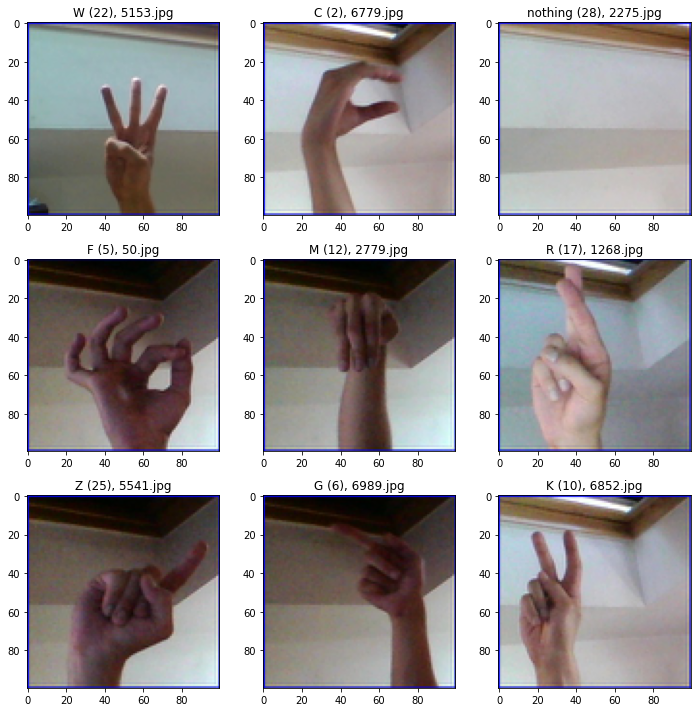

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(10,10))

for i in range(3):
  for j in range(3):
    random_number = python_random.randint(0,len(X_test) - 1)
    axes[i][j].imshow(X_test[random_number])
    axes[i][j].set_title(f"{preds.iloc[random_number][0]} ({labels[preds.iloc[random_number][0]]}), {random_number}.jpg")

fig.tight_layout()

# Exporting predictions as CSV

In [ ]:
preds.to_csv("submission.csv")

# For saving and loading models





In [ ]:
model.save("/content/drive/My Drive/CS412PROJ_DATA/model20EPOCH")

INFO:tensorflow:Assets written to: /content/drive/My Drive/CS412PROJ_DATA/model20EPOCH/assets


In [ ]:
from keras.models import load_model
model = load_model("/content/drive/My Drive/CS412PROJ_DATA/saved_model")

#TEST SET 2

Unzipping the file to Colab.

In [18]:
!unzip "/content/drive/My Drive/CS412PROJ_DATA/nonlabeled-test2.zip" -d "/content/data"

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/data/nonlabeled-test2/5499.jpg  
  inflating: /content/data/nonlabeled-test2/55.jpg  
  inflating: /content/data/nonlabeled-test2/550.jpg  
  inflating: /content/data/nonlabeled-test2/5500.jpg  
  inflating: /content/data/nonlabeled-test2/5501.jpg  
  inflating: /content/data/nonlabeled-test2/5502.jpg  
  inflating: /content/data/nonlabeled-test2/5503.jpg  
  inflating: /content/data/nonlabeled-test2/5504.jpg  
  inflating: /content/data/nonlabeled-test2/5505.jpg  
  inflating: /content/data/nonlabeled-test2/5506.jpg  
  inflating: /content/data/nonlabeled-test2/5507.jpg  
  inflating: /content/data/nonlabeled-test2/5508.jpg  
  inflating: /content/data/nonlabeled-test2/5509.jpg  
  inflating: /content/data/nonlabeled-test2/551.jpg  
  inflating: /content/data/nonlabeled-test2/5510.jpg  
  inflating: /content/data/nonlabeled-test2/5511.jpg  
  inflating: /content/data/nonlabeled-test2/5512.jpg  
  inflating: /content/

Function to load the TEST SET 2.

In [19]:
def load_test_set_2():
  
  DEBUG = False
  data_path = "/content/data/"
  X_test_2 = []
  img_size = 100,100

  if DEBUG: print("\nLoading X_test_2")
  for count, image_file in enumerate(sorted(os.listdir(join(data_path,"nonlabeled-test2")), key=lambda f: int(re.sub('\D', '', f)))):
    if DEBUG: print(f"—— {count+1}/7250, {image_file}")
    img = readImage(join(data_path,"nonlabeled-test2", image_file), img_size)
    if img is not None:
      X_test_2.append(img)
  
  X_test_2 = np.array(X_test_2)

  return X_test_2

Loading the images, preprocessing, getting the predictions, and exporting the predictions as CSV.

In [20]:
X_test_2 = load_test_set_2()

In [21]:
X_test_2 = X_test_2.astype('float32')
X_test_2 /= 255

In [22]:
def get_preds_df(X_test, model_name):
  preds = pd.DataFrame(pd.DataFrame(data=(model_name.predict(X_test) > 0.5).astype("int32"), columns = list(labels.keys())).idxmax(1), columns=["Prediction"])
  preds.index.name = "Id"
  return preds

In [23]:
preds = get_preds_df(X_test_2, model)
preds.to_csv("test_set_2_predictions.csv")

It seems that test labels of the `nonlabeled-test2` has been uploaded accidentally as a .npy file. Just out of curiosity, I wanted to check our test accuracy score :p

In [25]:
from sklearn.metrics import accuracy_score

In [26]:
y_test_2 = np.load("/content/drive/My Drive/CS412PROJ_DATA/labels.npy")

In [27]:
print(f"TEST SET 2 accuracy of our best model is: {accuracy_score(y_test_2,preds)}")

TEST SET 2 accuracy of our best model is: 0.9993793103448276
